# Esercizio 8: Variational MC e Path Integral MC
Si vuole studiare un sistema quantistico unidimensionale con potenziale 
$$
V(x) = x^4 - \frac{5}{2}x^2
$$


## Variational MC
Si cercano i parametri ottimali $\mu$ e $\sigma$ che minimizzino l'energia dello stato:
$$
\Psi_{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

Files eseguibili:

`optimize` calcola il valore di aspettazione dell'energia su una griglia di parametri $\mu$ e $\sigma$. Richiede come argomenti due intervalli $[ \mu_{min}, \mu_{max}] \times [\sigma_{min}, \sigma_{max}]$ e un numero che indichi quanti punti sono da prendere in tali intervalli.

`wavefunction` richiede come argomenti $\mu, \sigma$, nstep.

In [1]:
import matplotlib
from matplotlib import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import log, exp, sqrt
from statsmodels.tsa.stattools import acf

def data_blocking(data, block_size):
    if block_size <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    
    blocks = int(data.size/block_size)
    error = np.zeros(blocks)
    cumul_ave = np.zeros(blocks)
    block_ave = 0
    m_sum = 0
    m_sum2 = 0
    
    for i in range(blocks):
        block_sum = 0
        for j in range(block_size):
            block_sum += data[j+i*block_size]
        block_ave  = block_sum/block_size 
        m_sum += block_ave
        m_sum2 += block_ave**2
        cumul_ave[i] = m_sum/(i+1)
        if i==0:
            error[i]=0
        else:
            error[i] = np.sqrt( (m_sum2/(i+1) - (m_sum/(i+1))**2)/i )
    return cumul_ave, error

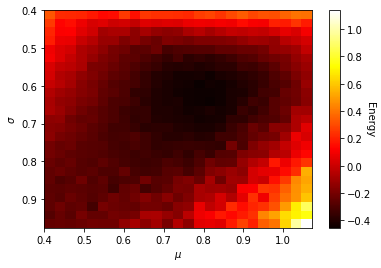

best mu =  0.82
best sigma =  0.64


In [2]:
folder = 'optimize/data/'

mu, sigma, energy_avg = np.loadtxt(folder + "mu_sigma_E.dat", unpack = True)

N = int(sqrt(len(mu)))
grid = energy_avg.reshape((N, N)).T

fig, axes = plt.subplots()
im = plt.imshow(grid, extent = (mu.min(), mu.max(), sigma.max(), sigma.min()), cmap = 'hot', 
                interpolation = "nearest")

axes.set_xlabel(r"$\mu$")
axes.set_ylabel(r"$\sigma$")
axes.set_aspect("auto")
cbar = fig.colorbar(im)
cbar.set_label('Energy', rotation=270)
plt.show()

index = np.argmin(energy_avg)
print('best mu = ', mu[index])
print('best sigma = ', sigma[index])

Di seguito è riportato uno studio dello stato ottimale ottenuto tramite il Variational MC, confrontato con la soluzione esatta (calcolata numericamente)

In [3]:
# Risolutore eq Schroedinger
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E_teo,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)


#### Autocorrelazione
Guardo come decade l'autocorrelazione per scegliere quanto fare grossi i blocchi

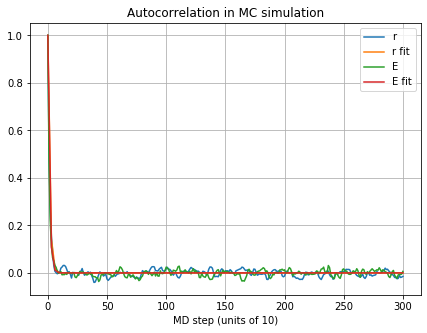

Decay length = 1.6
Decay length = 1.4


In [4]:
folder = 'optimize/data/'
maxlag = 300

plt.figure(figsize=(7,5))
r = np.loadtxt(folder + 'to_acorr.dat', usecols=(0))
acorr_r = acf(r, nlags=maxlag, fft=True) #calculate autocorr
plt.plot(range(maxlag+1), acorr_r, label='r') #plot autocorrelation
par_r, corr_r = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_r, p0=1) #fit autocorr
x_pl = np.linspace(0,maxlag,100)
plt.plot(x_pl, exp(-par_r*x_pl), label='r fit')

E = np.loadtxt(folder + 'to_acorr.dat', usecols=(1))
acorr_E = acf(E, nlags=maxlag, fft=True) #calculate autocorr
plt.plot(range(maxlag+1), acorr_E, label='E') #plot autocorrelation
par_E, corr_E = scipy.optimize.curve_fit(lambda t,a: np.exp(-a*t),  range(maxlag+1),  acorr_E, p0=1) #fit autocorr
x_pl = np.linspace(0, maxlag, 100)
plt.plot(x_pl, exp(-par_E*x_pl), label='E fit')

plt.title('Autocorrelation in MC simulation')
plt.xlabel('MD step (units of 10)')
plt.grid()
plt.legend()
plt.show()

print('Decay length = {:.1f}'.format( 1/par_r[0]))
print('Decay length = {:.1f}'.format( 1/par_E[0]))

Utilizzeremo quindi blocchi da 10 elementi

Ground state energy:  -0.46046587969271535


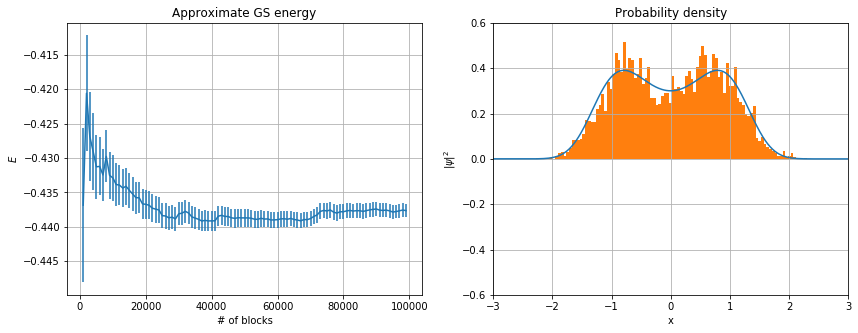

In [6]:
print("Ground state energy: ", E_teo[0])
#print("1st excited state energy: ", E[1])
#print("2nd excited state energy: ", E[2])

E = np.loadtxt('wavefunction/wavef.dat', usecols=(1))
E, err_E = data_blocking(E, 10)
blocks = np.arange(E.size)

fig, axs = plt.subplots(1,2,figsize=(14,5))
show_interval = 1000
axs[0].errorbar(blocks[1000::show_interval], E[1000::show_interval], err_E[1000::show_interval])
axs[0].grid()
axs[0].set_xlabel('# of blocks')
axs[0].set_ylabel(r'$E$')
axs[0].set_title('Approximate GS energy')
    
    
scale = 0.3
#plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
#plt.plot(x,(psi[1])**2)
#plt.plot(x,(psi[2])**2)

nbins = 100
axs[1].hist(r, nbins, density=True, label='Variational MC')
axs[1].grid()


axs[1].set_title('Probability density')
axs[1].set_ylabel(r'$ | \psi | ^2$')
axs[1].set_xlabel("x")
axs[1].grid(True)
axs[1].set_xlim((-3,3))
axs[1].set_ylim((-0.6,0.6))
    
plt.show()



## Path Integral MC
Sfrutteremo il mapping su un modello di polimeri per studiare il ground state e la matrice densità a temperatura finita del nostro sistema.

### Ground State (PIGS)

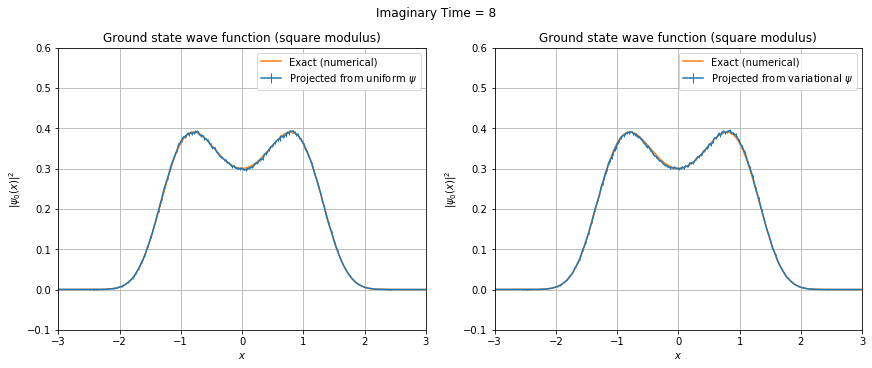

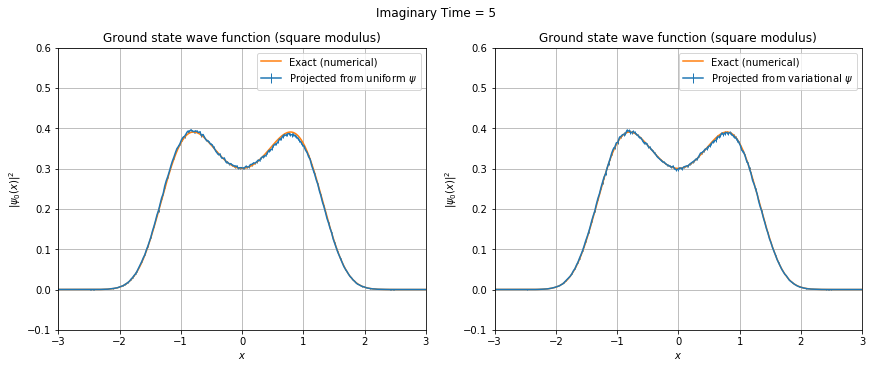

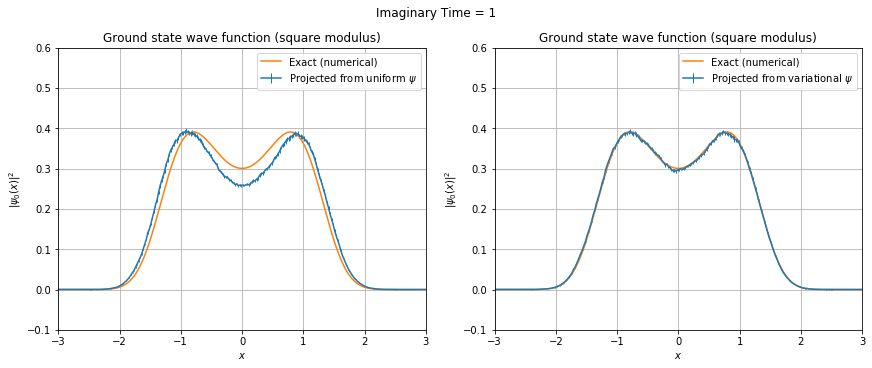

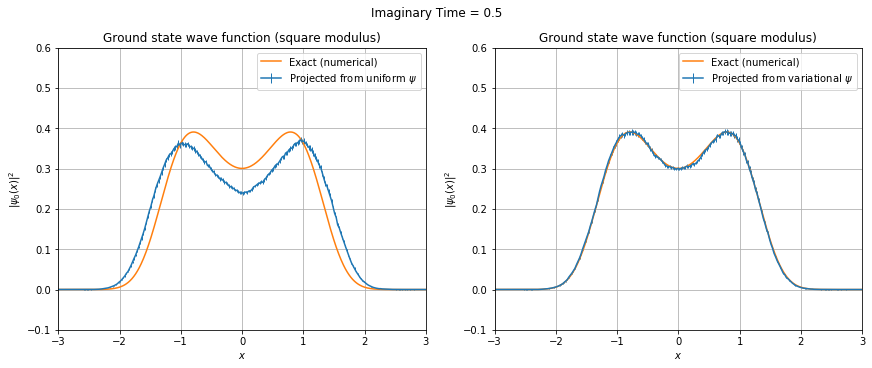

In [7]:
folder = "path_integral/pigs/"

for imt in ['8', '5', '1', '0.5']:
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5), constrained_layout=True)
    axes = axes.flatten()

    fig.suptitle('Imaginary Time = ' + imt)
    # Histogram of the square modulus of the wave function.
    x_bins, h_avg, h_err = np.loadtxt(folder + "probability_uniform" + imt + ".dat", unpack = True)
    axes[0].errorbar(
        x_bins,
        h_avg,
        yerr = h_err,
        elinewidth = 1,
        label = r"Projected from uniform $\psi$"
    )

    x_bins, h_avg, h_err = np.loadtxt(folder + "probability_variational" + imt + ".dat", unpack = True)
    axes[1].errorbar(
        x_bins,
        h_avg,
        yerr = h_err,
        elinewidth = 1,
        label = r"Projected from variational $\psi$"
    )

    for ax in axes:
        ax.set_title("Ground state wave function (square modulus)")
        ax.set_ylabel(r"$|\psi_0(x)|^2$")
        ax.set_xlabel(r"$x$")
        ax.plot(x, (psi[0])**2, label = "Exact (numerical)")
        ax.set_xlim((-3, 3))
        ax.set_ylim((-0.1, 0.6))
        ax.legend()
        ax.grid(True)

    plt.show()

La differenza tra proiettare dallo stato con funzione d'onda costante e proiettare dallo stato ottimale secondo il MC variazionale si vede nel momento in cui viene ridotto il tempo immaginario. Da temperature al di sotto di $T=1$ i risultati sono fortemente corrotti per la funzione d'onda costante.

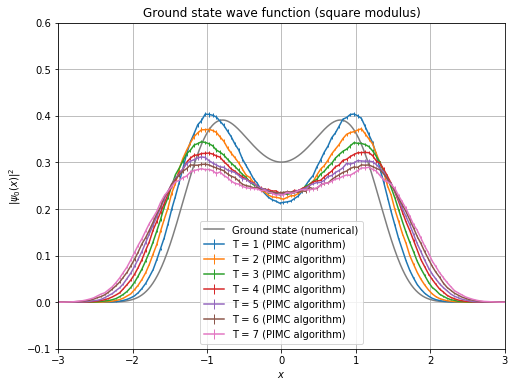

In [8]:
folder = "path_integral/pimc/"
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

# Histogram of the square modulus of the wave function.
for temp in ["1", '2', '3', '4', '5', '6', '7']:
    x_bins, h_avg, h_err = np.loadtxt(folder + "probability_" + temp + ".dat", unpack = True)
    axes.errorbar(
        x_bins,
        h_avg,
        yerr = h_err,
        elinewidth = 1,
        label = "T = " + temp + " (PIMC algorithm)"
    )
# (The results are the same regardless of the trial wavefunction.)

axes.set_title("Ground state wave function (square modulus)")
axes.set_ylabel(r"$|\psi_0(x)|^2$")
axes.set_xlabel(r"$x$")
axes.grid(True)
axes.plot(x, (psi[0])**2, label = "Ground state (numerical)")
axes.set_xlim((-3, 3))
axes.set_ylim((-0.1, 0.6))
axes.legend()
axes.grid(True)

plt.show()

Vediamo come per temperature basse la distribuzione si avvicina a quella del ground state mentre all'aumentare della temperatura, sempre più stati eccitati sono coinvolti e quindi complessivamente la distribuzione si allarga